# Multi-class Image Classification with Transfer Learning and TensorFlow

## Introduction 

You are walking down the street and you meet a four legged stranger...

In [ ]:
# Load image
from IPython.display import Image
from IPython.core.display import HTML 
# Image(url= "https://www.hdwallpaper.nu/wp-content/uploads/2015/03/Long-Haired-Golden-Retriever.jpg", unconfined=True)

# Uncomment the remaining lines of code for a smaller image
html1 = '<img src="https://www.hdwallpaper.nu/wp-content/uploads/2015/03/Long-Haired-Golden-Retriever.jpg" width="460" height="360" align="center"/>'
HTML(html1)

"Sooooo Cute!" <br>
"What's their name?" <br>
"How old are they?" <br>
<br>

Like some people, you may also ask, "what kind of breed is that?" <br>  

But, there will always be someone other than the owner who knows that our little friend is a golden retriever. 
<br> <br>

How do they know that? Answering this question is the purpose of this notebook. <br> <br>  

To do this, I will use data from Kaggle which has over 10,000 labelled images of 120 different dog breeds. This is multi-class image classification as we are classifying multiple dog breeds from images.

For the model, I will be using a pretrained model from TensorFlow Hub. This is transfer learning, which leverages the parallelism between this dataset and a model that has been trained to classify images.


## Data

TensorFlow 2.0 to process the data into Tensors

In [ ]:
# Import TF 2.x if it is not defaulted on Colab
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

Check if TensorFlow and the Hub are available

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Runtime > Change runtime type > Hardware Accelerator > GPU
print("GPU available!" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.3.0
Hub version: 0.10.0
not available :(


Import data

In [ ]:
!wget https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip # download files from Dropbox as zip

import os
import zipfile

local_zip = 'dog-breed-identification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('Dog Vision') # unzip the files into a file called "Dog Vision"
zip_ref.close()

--2020-11-27 16:03:14--  https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip [following]
--2020-11-27 16:03:14--  https://www.dropbox.com/s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebe150e4c414c78e81fed13570.dl.dropboxusercontent.com/cd/0/inline/BEDJltKfYrFzmQhPPs3uVck_V49SZco1d2unbbufAqyW3tcEYJIeQtehfq-9zdaV84rNIXHNJdHROKoByyiYCxblBomaCq3nLVeAajVGJZZyVkuad70504SoENzytlWvxZ4/file# [following]
--2020-11-27 16:03:15--  https://ucebe150e4c414c78e81fed13570.dl.dropboxusercontent.com/cd/0/inline/BEDJltKfYrFzmQhPPs3uVck_V49SZco1d2unbbufAqyW3tcEYJIeQtehfq-9zda

Check the data labels

In [ ]:
import pandas as pd

labels = pd.read_csv("Dog Vision/labels.csv")

print(labels.describe())
print(labels.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c3b19b9e1ce0c005511fa14e2d9a89ec  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


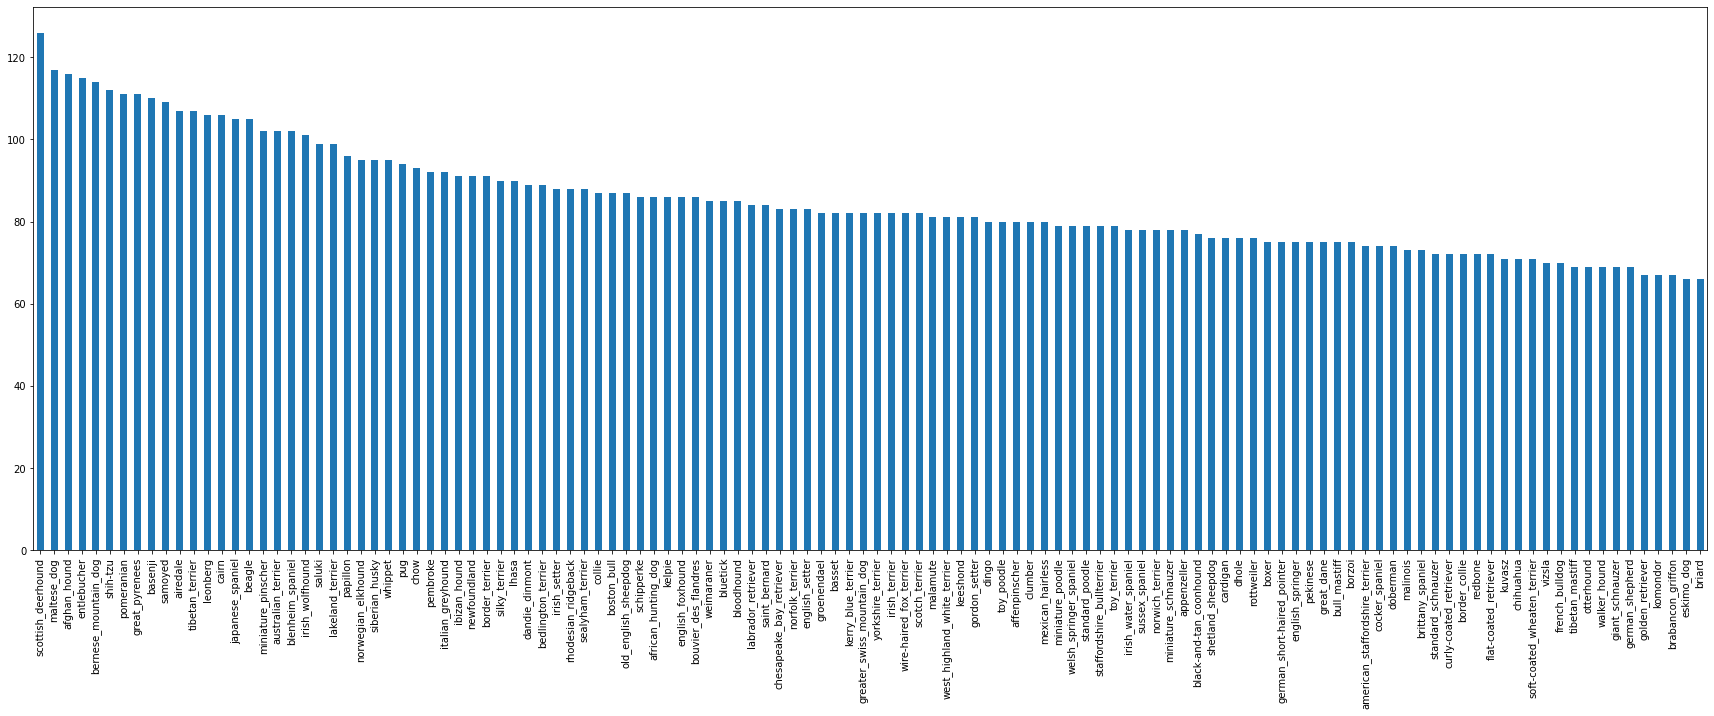

In [ ]:
import matplotlib.pyplot as plt

labels.breed.value_counts().plot.bar(figsize = (30, 10))
plt.show()

There are 120 unique dog breeds and 10222 images. The label with the fewest number of images is acceptable since there are over 60 images. A golden standard based on the Google Cloud Platform is 10 images.

In [11]:
# Turn the dataframe into a NumPy array
import numpy as np
labels = labels.breed.to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [13]:
totalBreeds = np.unique(labels)
len(totalBreeds)

120